<a href="https://colab.research.google.com/github/AllanKamimura/AI/blob/master/IEEE/Classification_Pokemon_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Init

In [ ]:
# import libraries
import os
import datetime
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from google.colab import files
from google_drive_downloader import GoogleDriveDownloader
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%load_ext tensorboard

In [ ]:
file_id = "1lKfmEjyovEvvZ2zBUkdJwl2fnF4C5OyM" # pokemon dataset id
folder = "dataset" # main folder

# download data
GoogleDriveDownloader.download_file_from_google_drive(
    file_id = file_id,
    dest_path = "/content/pokemon.zip",
    unzip = True
)


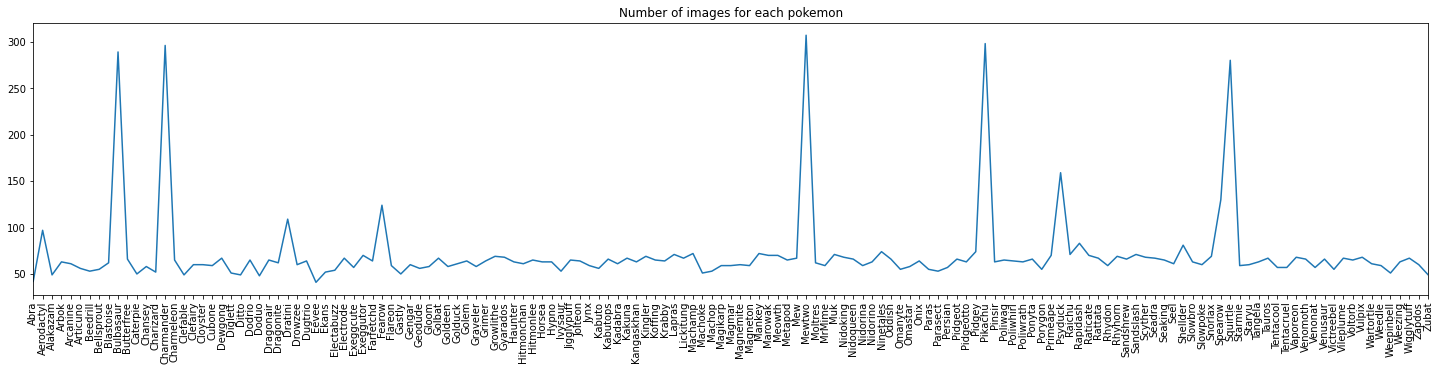

In [3]:
# explore data
pokemon_count = {}
index_weight = {} # class imbalance => class_weight = total_images / class_samples
pokemon_list = os.listdir("/content/{}".format(folder))
pokemon_list.sort() # alphabetical order

for index, pokemon in enumerate(pokemon_list):
    pokemon_count[pokemon] = len(os.listdir("/content/{}/{}".format(folder, pokemon)))
    index_weight[index] = 1 / len(os.listdir("/content/{}/{}".format(folder, pokemon)))

index_weight = {k: v * total for total in (sum(index_weight.values()),) for k, v in index_weight.items()}

fig = plt.figure(figsize = (25, 5))
sns.lineplot(x = list(pokemon_count.keys()), y = list(pokemon_count.values())).set_title('Number of images for each pokemon')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.show()

# Create data feed

In [ ]:
seed = 2
height, width = 224, 224
datagen = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
    validation_split = 0.1)

train_data = datagen.flow_from_directory(
    directory = "/content/{}".format(folder),
    target_size = (height, width),
    shuffle = True,
    seed = seed,
    batch_size = 20,
    subset = "training"
)

val_data = datagen.flow_from_directory(
    directory = "/content/{}".format(folder),
    target_size = (height, width),
    shuffle = True,
    seed = seed,
    batch_size = 20,
    subset = "validation"
)

test_datagen = ImageDataGenerator(
    validation_split = 0.1
)

test_data = test_datagen.flow_from_directory(
    directory = "/content/{}".format(folder),
    target_size = (height, width),
    shuffle = True,
    seed = seed,
    batch_size = 20,
    subset = "validation"
)

# get the inverse of class_indices
indices_class = {value: key for key, value in val_data.class_indices.items()}
print(indices_class)


# Efficient + Xception + mobile model

In [ ]:
def base_model(shape):
    """
    base_model as a function, create the convolutional layers
    Parameters:
    shape = the shape of the input, tuple (height, width, channels)
    Returns:
    a tensorflow model object
    """
    # make an input layer, with shape equals to the input_shape
    input = tf.keras.layers.Input(shape = shape, name = "input_layer")
    
    # preprocess the input
    efficient_input = tf.keras.applications.efficientnet.preprocess_input(input)
    xception_input = tf.keras.applications.xception.preprocess_input(input)
    mobile_input = tf.keras.applications.mobilenet_v3.preprocess_input(input)

    # instantiate the pre-trained model
    efficient_model = tf.keras.applications.EfficientNetB7(include_top = False, # don't include the Fully Conected Layers
                                                           input_shape = input_shape, 
                                                           pooling = "max", # returns a flatten layer
                                                           weights = "imagenet") 
    
    xception_model = tf.keras.applications.Xception(include_top = False,
                                                    input_shape = input_shape,
                                                    pooling = "max",
                                                    weights = "imagenet")
    
    mobile_model = tf.keras.applications.MobileNetV3Small(include_top = False,
                                                          input_shape = input_shape,
                                                          pooling = "max",
                                                          minimalistic = True,
                                                          weights = "imagenet")
    
    efficient_model.trainable = False # freeze model weights training
    xception_model.trainable = False
    mobile_model.trainable = False

    efficient_output = efficient_model(efficient_input) # feed the each preprocessed image in the right pre-trained model
    xception_output = xception_model(xception_input)
    mobile_output = mobile_model(mobile_input)

    y = tf.keras.layers.Concatenate()([efficient_output, # concatenate the 3 outputs into a single layer
                                       xception_output,
                                       mobile_output])
    
    model = tf.keras.models.Model( # instantiate the tensorflow model with input as the input and y as the output
        inputs = input,
        outputs = y)  
    
    return model

def my_model(n_class):
    model = tf.keras.models.Sequential([
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units = 4096, activation = "relu", kernel_initializer = 'he_uniform'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units = 1024, activation = "relu", kernel_initializer = 'he_uniform'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units = 256, activation = "relu", kernel_initializer = 'he_uniform'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units = n_class, activation = "softmax")
    ])
    return model  

input_shape = (height, width, 3)
n_class = len(train_data.class_indices.keys())

conv_model = base_model(shape = (height,width,3))
fc_model = my_model(n_class = n_class)

model = tf.keras.models.Sequential([conv_model, fc_model])

model.summary()                              

# train the model

In [18]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(
        tf.keras.optimizers.schedules.ExponentialDecay( # after 6000 steps, the learning rate is updated to half the initial value
            initial_learning_rate = 0.0004, decay_steps = 6000, decay_rate = 0.5 # this number is a hyperparameter, so adjust accordingly
    )),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ["accuracy"]
)

In [ ]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq = 1)

callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 3, restore_best_weights = True)

history = model.fit(train_data,
                    validation_data = val_data,
                    epochs = 20,
                    callbacks = [tensorboard_callback, callback],
                    class_weight = index_weight # apply the class_weight
                    )

In [ ]:
%tensorboard --logdir logs


# Visualize predits

In [ ]:
images, labels = test_data.next() # get the next batch of test data
predicts = model.predict(images) # get the predictions

n_rows = (len(images) // 4) + 1
plt.figure(figsize = (12,n_rows * 4))

for index, image in enumerate(images):
    plt.subplot(n_rows, 4, index + 1)
    image = np.asarray(image, dtype = np.uint8)
    plt.imshow(image)
    plt.title("real: {}\n predict:{}\n score:{:.3f}".format(
        indices_class[np.argmax(labels[index])], 
        indices_class[np.argmax(predicts[index])],
        np.max(predicts[index])
    ))

# load my saved weights

In [ ]:
file_id = "1MGGk_DDc2hX4wBol_Q8CABj1fsuBLxt6"
save_file = "/content/save.h5"
GoogleDriveDownloader.download_file_from_google_drive(
    file_id = file_id,
    dest_path = save_file
)

my_model = tf.keras.models.load_model(save_file)
my_model.evaluate(test_data)

In [ ]:
images, labels = test_data.next() # get the next batch of test data
predicts = my_model.predict(images) # get the predictions

n_rows = (len(images) // 4) + 1
plt.figure(figsize = (12,n_rows * 4))

for index, image in enumerate(images):
    plt.subplot(n_rows, 4, index + 1)
    image = np.asarray(image, dtype = np.uint8)
    plt.imshow(image)
    plt.title("real: {}\n predict:{}\n score:{:.3f}".format(
        indices_class[np.argmax(labels[index])], 
        indices_class[np.argmax(predicts[index])],
        np.max(predicts[index])
    ))